# **Laptop Price Predictor**
<small>Martina Speciale, 603047 \\
Data Mining & Machine Learning project 2023-2024




In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# this is done to prevent errors in the deployment phase on Streamlit Cloud :
# using the previous version (1.2.2) there were conflicts that prevented
# the correct loading of the pickle files we will store our models on

# This is the scikit-learn version that Streamlit uses
!pip install scikit-learn==1.3.2

In [105]:
data_path = '/content/drive/MyDrive/LaptopPricePredictor/data/laptop_data.csv'
df = pd.read_csv(data_path, index_col=0)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


**We'll convert Indian rupees to Euros manually: to do that we need to know the exchange rate.**

$Euros = \frac{Indian Rupees}{ExchangeRate}$


$1 ₹ = 0.0110699 €$

Indian Rupee (INR, ₹) to Euro (EUR, €) conversion — Last updated Jul 9, 2024, 07:48 UTC

In [106]:
def convert_currency(args):
    amount, currency = args
    rates = {'INR': 1, 'EUR': 0.0110699, 'USD': 0.0119769}
    return rates[currency] * amount

# convert 'Price(INR)' from INR to EUR
df['Price'] = df['Price'].apply(lambda x: convert_currency((x, 'EUR')))
df = df.rename(columns={"Price": "Price(EUR)"})
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price(EUR)
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,790.154885
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,530.198652
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,339.137456
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,1496.598850
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1063.770985


In [107]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Price(EUR)'],
      dtype='object')

In [108]:
df.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price(EUR)          0
dtype: int64

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price(EUR)        1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


In [110]:
catvars = df.select_dtypes(include=['object']).columns
numvars = df.select_dtypes(include = ['int32','int64','float32','float64']).columns
print('Categorical Features : \n', catvars)
print('\n Numerical Features : \n', numvars)


Categorical Features : 
 Index(['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory',
       'Gpu', 'OpSys', 'Weight'],
      dtype='object')

 Numerical Features : 
 Index(['Inches', 'Price(EUR)'], dtype='object')


In [111]:
def uniquevalues(feature):
    print(f'Unique values for {feature} : {df[feature].unique()}')

def valuecounts(feature):
    print(f'Valuecounts for {df[feature].value_counts()}')


for feature in catvars:
    uniquevalues(feature)
    print("."*100)
    valuecounts(feature)
    print("-"*100)

Unique values for Company : ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
....................................................................................................
Valuecounts for Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Unique values for TypeName : ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
....................................................................................................
Valuecounts for TypeName
N

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price(EUR)        1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


# **Exploratory Data Analysis (EDA)**

## Distribution of Prices

<Axes: xlabel='Price(EUR)', ylabel='Density'>

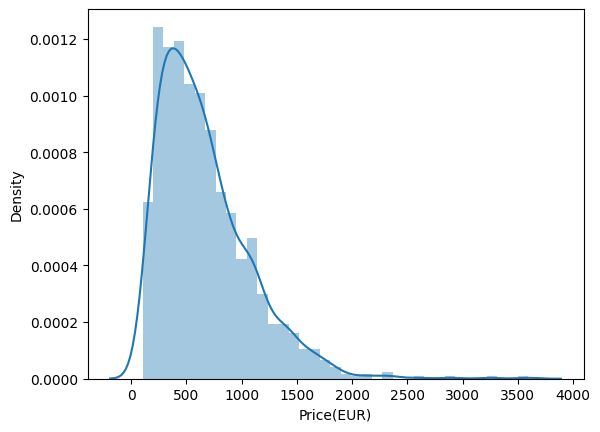

In [113]:
sns.distplot(df['Price(EUR)'])

## Countplots for Categorical Variables
* Company
* TypeName
* RAM
* OpSys


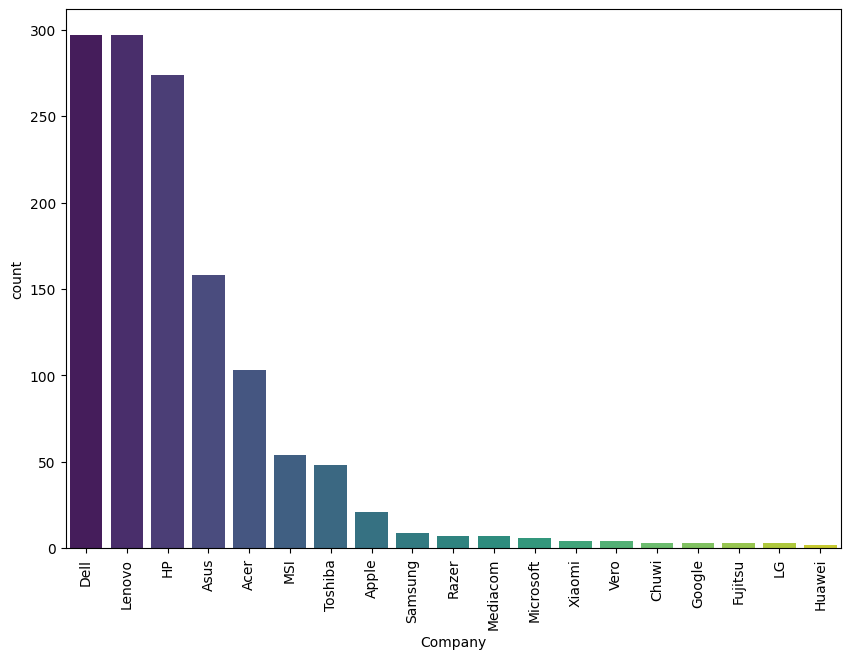

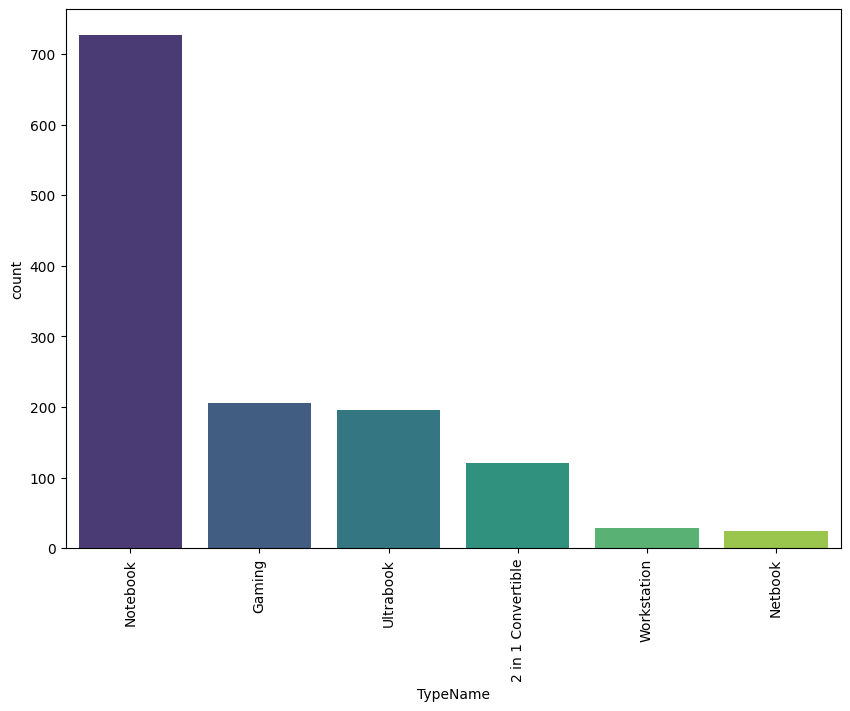

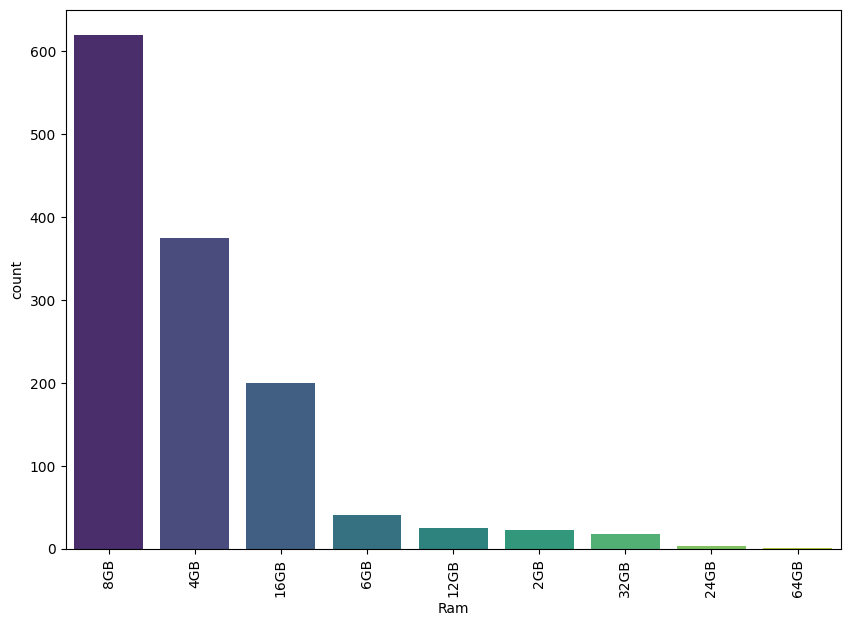

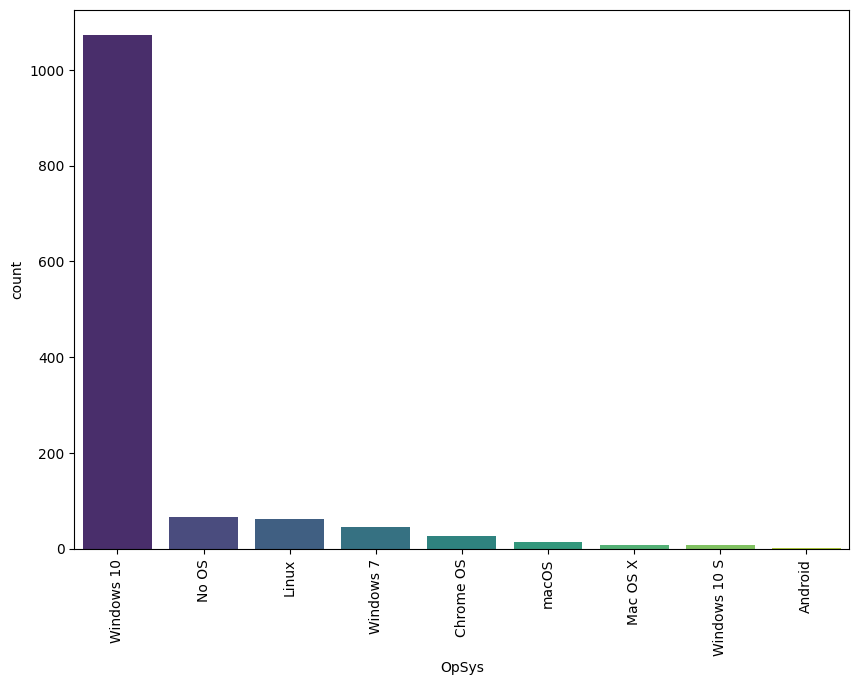

In [114]:
def drawplot(col):
    plt.figure(figsize=(10,7))
    sns.countplot(data=df, x=col, palette="viridis", order = df[col].value_counts().index) # Access the column using the new name
    plt.xticks(rotation=90)

cols = ['Company', 'TypeName','Ram','OpSys'] # Use the updated column name here
for col in cols:
    drawplot(col)

### From categorical to numerical: RAM and Weight

In [115]:
df['Ram'] = df['Ram'].str.replace('GB','')
df['Weight'] = df['Weight'].str.replace('kg','')

# RAM column : string -> integer
df['Ram'] = df['Ram'].astype('int32')

# Weight column : string-> float
df['Weight'] = df['Weight'].astype('float32')

df = df.rename(columns={"Ram": "RAM(GB)", 'Weight': 'Weight(kg)'})
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR)
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985


#### Average price per Company

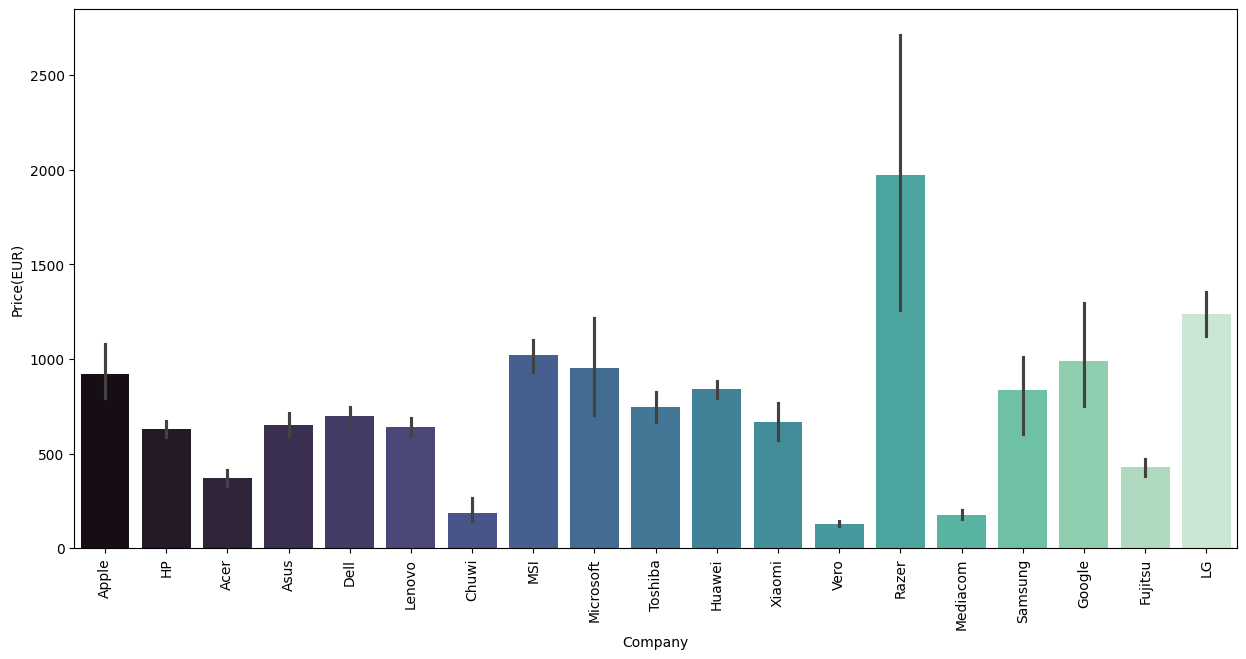

In [116]:
plt.figure(figsize=(15,7))
sns.barplot(data=df, x='Company', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 90)
plt.show()

### Typologies (TypeName)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Notebook'),
  Text(1, 0, 'Gaming'),
  Text(2, 0, 'Ultrabook'),
  Text(3, 0, '2 in 1 Convertible'),
  Text(4, 0, 'Workstation'),
  Text(5, 0, 'Netbook')])

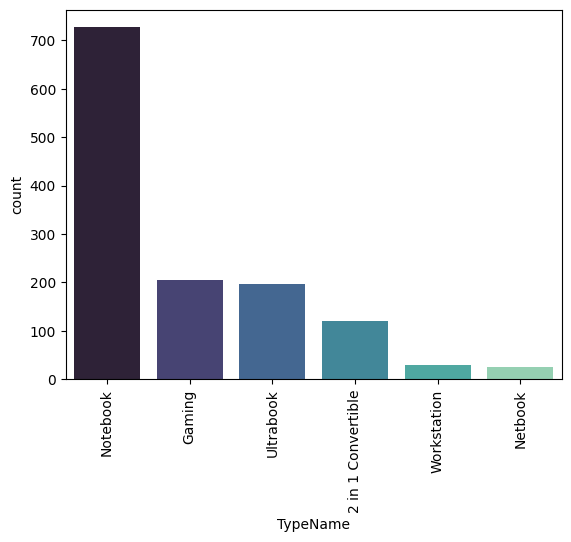

In [117]:
sns.countplot(x=df['TypeName'],palette='mako', order = df['TypeName'].value_counts().index)
plt.xticks(rotation = 90)

#### Average Price per Typology

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Ultrabook'),
  Text(1, 0, 'Notebook'),
  Text(2, 0, 'Netbook'),
  Text(3, 0, 'Gaming'),
  Text(4, 0, '2 in 1 Convertible'),
  Text(5, 0, 'Workstation')])

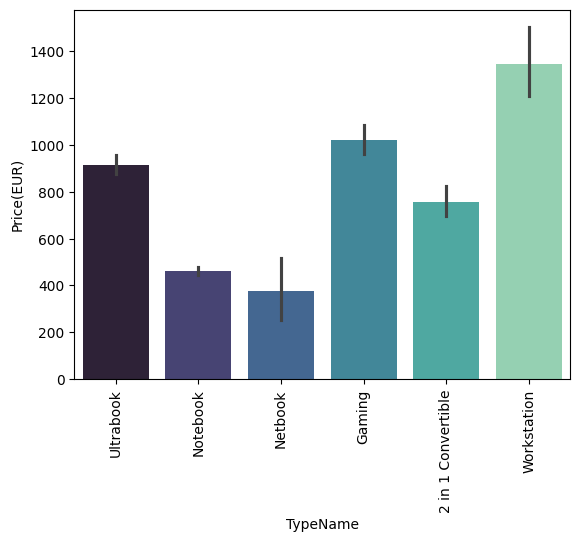

In [118]:
sns.barplot(data=df, x='TypeName', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 90)

### Iches vs Price

<Axes: xlabel='Inches', ylabel='Price(EUR)'>

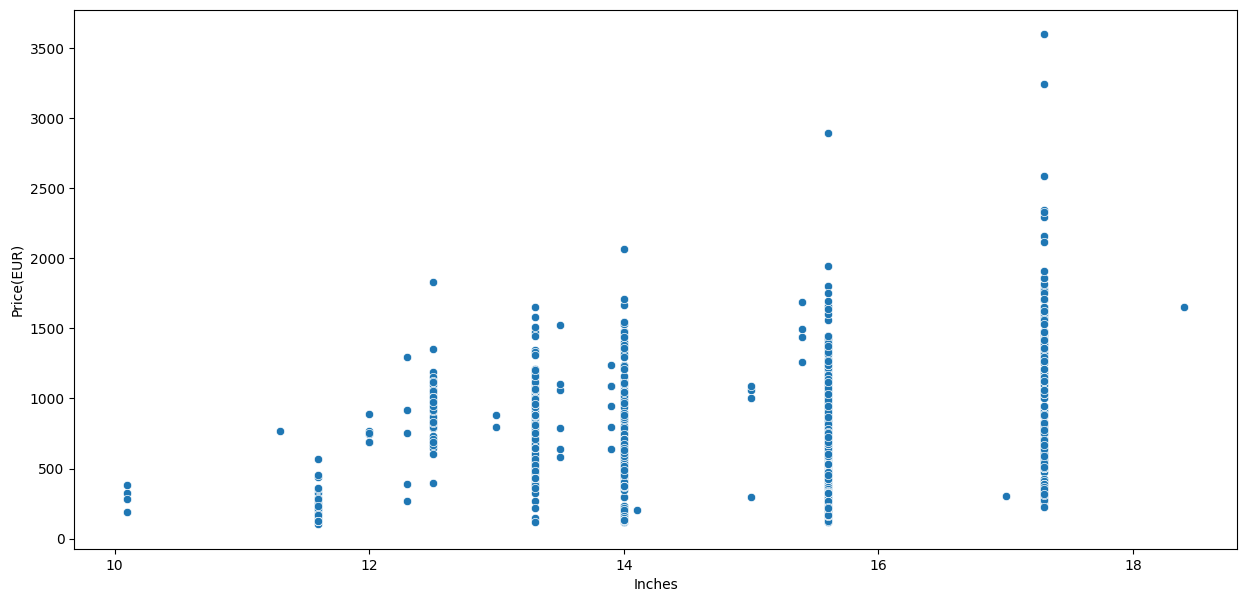

In [119]:
plt.figure(figsize=(15,7))
sns.scatterplot(x = df['Inches'],y = df['Price(EUR)'])

**For the `Screen Resolution` feature we focus on:**
1. `Touch Screen`
2. `IPS Panel`


In [120]:
df['ScreenResolution'].value_counts()

ScreenResolution
Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x14

### New Feature: **TouchScreen**

In [121]:
# New column 'Touchscreen'
# 1 --> touchscreen
# 0 --> no touchscreen

df['TouchScreen'] = df['ScreenResolution'].apply(
    lambda element:1 if 'Touchscreen' in element else 0
)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0


In [122]:
df.sample(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen
110,Asus,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce MX150,Windows 10,1.50,744.332991,0
473,Dell,Ultrabook,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 8250U 1.6GHz,8,256GB SSD,Intel UHD Graphics 620,Windows 10,1.42,1086.330998,1
915,Lenovo,Notebook,13.3,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4,128GB SSD,Intel HD Graphics 620,Windows 10,1.44,519.617564,0
80,Dell,Ultrabook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8,256GB SSD,Intel UHD Graphics 620,Windows 10,1.88,646.519851,0
1021,Toshiba,Ultrabook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 10,1.20,937.788792,0


<Axes: xlabel='TouchScreen', ylabel='count'>

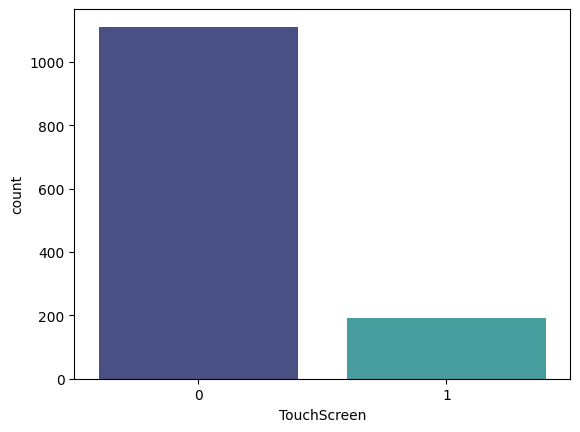

In [123]:
sns.countplot(x=df['TouchScreen'], palette="mako")

#### TouchScreen vs Price

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

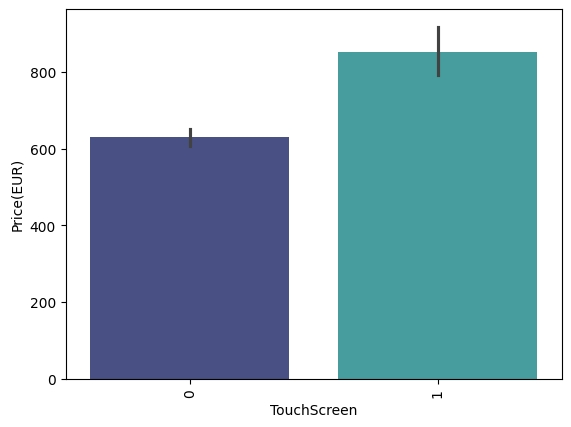

In [124]:
sns.barplot(data=df, x='TouchScreen', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 'vertical')

## New Feature : **IPS**

In [125]:
# New column IPS
# 1 --> IPS monitor
# 0 --> no IPS monitor

df['IPS'] = df['ScreenResolution'].apply(
    lambda element:1 if "IPS" in element else 0
)
df.sample(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS
417,HP,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,8,256GB SSD,Intel HD Graphics 520,Windows 10,1.43,884.706408,0,0
184,Xiaomi,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8,256GB SSD,Nvidia GeForce MX150,No OS,1.95,707.175322,0,1
712,Dell,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,1TB HDD,Intel HD Graphics 620,Linux,1.98,428.197901,0,0
945,Lenovo,Gaming,15.6,IPS Panel Full HD 1920x1080,AMD FX 8800P 2.1GHz,16,512GB SSD + 1TB HDD,AMD Radeon R9 M385,Windows 10,2.50,589.214468,0,1
1172,Asus,Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,4,500GB HDD,Intel HD Graphics,Windows 10,2.20,217.637776,0,0


<Axes: xlabel='IPS', ylabel='count'>

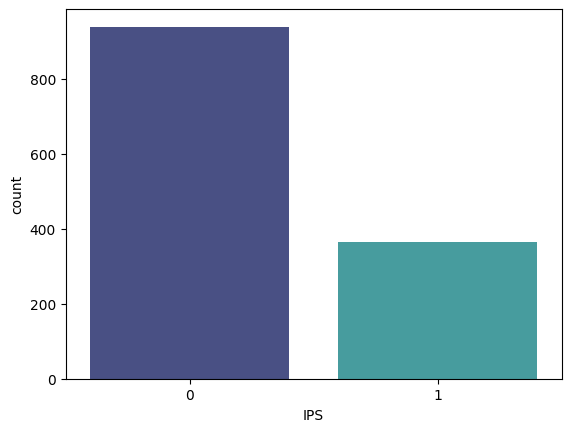

In [126]:
sns.countplot(x=df['IPS'],palette='mako')

#### IPS vs Price

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

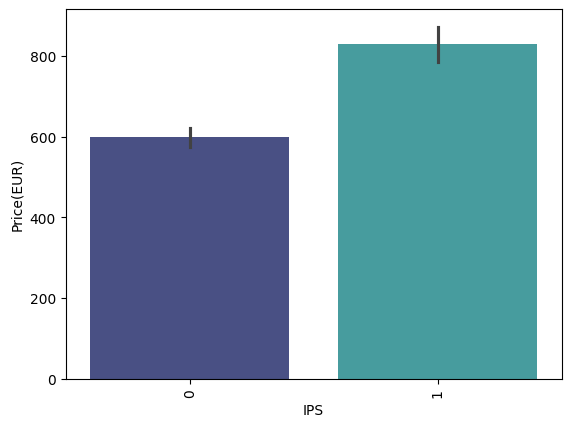

In [127]:
sns.barplot(data=df, x='IPS', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 90)

# **Extracting X Resolution and Y Resolution**

In [128]:
# resolution dataframe resdf to store x and y resolution independently
# [..]<x_res>x<y_res> --> 'x' : used to split on
# n=1 : limit for the number of splits in output
# expand=True : expand the split strings into separate columns

resdf = df['ScreenResolution'].str.split('x', n=1, expand=True)
resdf.head()

,0,1
0,IPS Panel Retina Display 2560,1600
1,1440,900
2,Full HD 1920,1080
3,IPS Panel Retina Display 2880,1800
4,IPS Panel Retina Display 2560,1600


In [129]:
resdf = df['ScreenResolution'].str.split('x', n=1, expand=True)

df['X_res'] = resdf[0]
df['Y_res'] = resdf[1]
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,X_res,Y_res
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,IPS Panel Retina Display 2560,1600
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,1440,900
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,Full HD 1920,1080
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,IPS Panel Retina Display 2880,1800
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,IPS Panel Retina Display 2560,1600


In [130]:
# extract the digits from X_res using regex
# \d+ : the string must begin with an integer number
# \.? : include all the digits that come after
# \d+ : the string must end with an integer number

df['X_res'] = df['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x:x[0])

df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,X_res,Y_res
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,2560,1600
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,1440,900
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,1920,1080
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,2880,1800
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,2560,1600


In [131]:
# categorical --> numerical
df['X_res'] = df['X_res'].astype('int')
df['Y_res'] = df['Y_res'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   RAM(GB)           1303 non-null   int32  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight(kg)        1303 non-null   float32
 10  Price(EUR)        1303 non-null   float64
 11  TouchScreen       1303 non-null   int64  
 12  IPS               1303 non-null   int64  
 13  X_res             1303 non-null   int64  
 14  Y_res             1303 non-null   int64  
dtypes: float32(1), float64(2), int32(1), int64(4), object(7)
memory usage: 152.7+ KB


<Axes: >

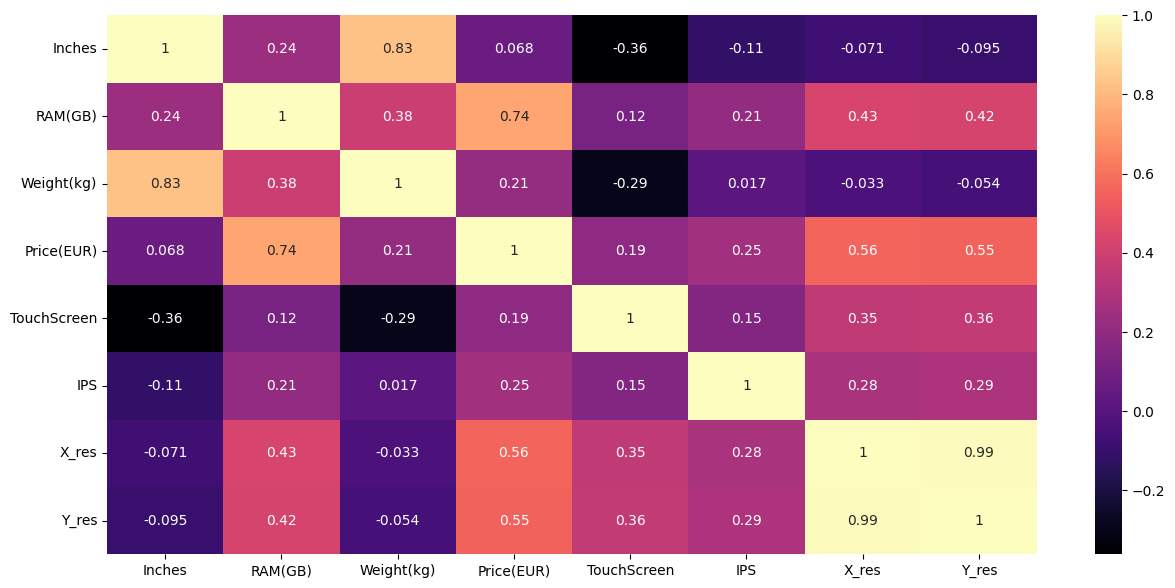

In [132]:
numvars = df.select_dtypes(include = ['int32','int64','float32','float64']).columns
plt.figure(figsize=(15,7))
sns.heatmap(df[numvars].corr(),annot=True,cmap='magma')

In [133]:
df[numvars].corr()['Price(EUR)']

Inches         0.068197
RAM(GB)        0.743007
Weight(kg)     0.210370
Price(EUR)     1.000000
TouchScreen    0.191226
IPS            0.252208
X_res          0.556529
Y_res          0.552809
Name: Price(EUR), dtype: float64

## New Feature : **PPI**

**Looking at the heatmap we can see how `X_res` and `Y_res` are positively correlated with `Price(EUR)` with a Pearson correlation coefficient equal to $0.55$**

**It is also clear how our two independent variables `X_res` and `Y_res` are highly correlated with each other (having a Pearson's correlation equal to 0.99). We say that they are collinear.**
**We can create a new feature `PPI` (Pixels Per Inch), combining them with `Inches`, that shows a considerably lower correlation coefficient.**

**PPI (Pixels per inch) describes the detail of an image file when the print size is known. For example, a 100×100 pixel image printed in a 2 inch square has a resolution of 50 pixels per inch. Here is the formula to compute it:**

$$
    PPI = \frac{\sqrt{X_{res}^2+Y_{res}^2}}{Inches}
$$

In [134]:
df['PPI'] = ( (df['X_res']**2 + df['Y_res']**2)**0.5 / df['Inches'] ).astype('float')
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,X_res,Y_res,PPI
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,2560,1600,226.983005
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,1440,900,127.677940
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,1920,1080,141.211998
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,2880,1800,220.534624
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,2560,1600,226.983005


In [135]:
numvars = df.select_dtypes(include = ['int32','int64','float32','float64']).columns
df[numvars].corr()['Price(EUR)']

Inches         0.068197
RAM(GB)        0.743007
Weight(kg)     0.210370
Price(EUR)     1.000000
TouchScreen    0.191226
IPS            0.252208
X_res          0.556529
Y_res          0.552809
PPI            0.473487
Name: Price(EUR), dtype: float64

**`PPI`, which is a combination of three features, has a good correlation with `Price`. We can therefore decide to use it and drop `Inches, X_res, Y_res`. Having preprocessed `ScreenResolution` to extract `X_res` and `Y_res`, we can drop that too.**

In [136]:
df.drop(columns=['ScreenResolution','Inches','X_res','Y_res'],inplace=True)
df.head()

,Company,TypeName,Cpu,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI
0,Apple,Ultrabook,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005
1,Apple,Ultrabook,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940
2,HP,Notebook,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998
3,Apple,Ultrabook,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624
4,Apple,Ultrabook,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005


## CPU
We now need to process the `CPU` column in order to be able to get
good insights from it

In [137]:
df = df.rename(columns={"Cpu": "CPU"})

In [138]:
df['CPU'].value_counts()

CPU
Intel Core i5 7200U 2.5GHz       190
Intel Core i7 7700HQ 2.8GHz      146
Intel Core i7 7500U 2.7GHz       134
Intel Core i7 8550U 1.8GHz        73
Intel Core i5 8250U 1.6GHz        72
                                ... 
Intel Core M M3-6Y30 0.9GHz        1
AMD A9-Series 9420 2.9GHz          1
Intel Core i3 6006U 2.2GHz         1
AMD A6-Series 7310 2GHz            1
Intel Xeon E3-1535M v6 3.1GHz      1
Name: count, Length: 118, dtype: int64

Intel and AMD are leading companies in the production of processors. Intel, in particular, has a long-standing reputation for producing high-performance and reliable processors used in a wide range of computing devices, from personal computers to servers. AMD, while coming in second, also offers competitive processors with strong performance.

Intel's processor lineup includes several key families. Looking at our data we can find:

1. **Intel Core i3**: These processors are designed for budget-friendly, entry-level computing. They offer solid performance for everyday tasks.

2. **Intel Core i5**: Positioned in the mid-range, i5 processors provide a balance of performance and value. They are suitable for more demanding applications, including gaming, content creation, and multitasking.

3. **Intel Core i7**: Targeting high-end users, i7 processors deliver superior performance for intensive tasks. They are ideal for gaming, video editing, and other resource-heavy applications.

Intel achieves the production of these popular processors through advanced semiconductor manufacturing processes. They utilize cutting-edge technology to create microprocessors with billions of transistors on a single chip, enhancing speed, efficiency, and overall performance.

**Taking into account what we just discussed, we will consider:**
1. **Intel Processors (`i3, i5, i7, other`)**
2. **AMD Processors (`AMD`)**
3. **Other**
**To do that, by looking at the data at our disposal, it's easy to see how we'll need to extract the first three words from each instance in the `CPU` column, that identify the type of processor**



In [139]:
df['CPU_name'] = df['CPU'].apply(lambda text:" ".join(text.split()[:3]))
df.head()

,Company,TypeName,CPU,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU_name
0,Apple,Ultrabook,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5
1,Apple,Ultrabook,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5
2,HP,Notebook,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5
3,Apple,Ultrabook,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7
4,Apple,Ultrabook,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5


In [140]:
df.CPU.unique()
cond = df['CPU_name'].str.contains('Intel|AMD')
df[~cond]

,Company,TypeName,CPU,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU_name
1191,Samsung,2 in 1 Convertible,Samsung Cortex A72&A53 2.0GHz,4,32GB Flash Storage,ARM Mali T860 MP4,Chrome OS,1.15,388.681015,1,1,234.5074,Samsung Cortex A72&A53


In [141]:
# just one laptop in the dataset contains a processor which is neither Inter nor AMD
# --> we can remove this single instance

df.drop(df[~cond].index, inplace=True)

In [142]:
# ['Intel Core i7', 'Intel Core i5', 'Intel Core i3'] -->  unchanged
# Other Intel Models                                  --> 'Other Intel Processor'
# The remaining will be all                           --> 'AMD

def processortype(text):

    if text=='Intel Core i7' or text=='Intel Core i5' or text=='Intel Core i3':
        return text

    else:
        if text.split()[0]=='Intel':
            return 'Other Intel'

        else:
            return 'AMD'



df['CPU_name'] = df['CPU_name'].apply(lambda text:processortype(text))
df.head()

,Company,TypeName,CPU,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU_name
0,Apple,Ultrabook,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5
1,Apple,Ultrabook,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5
2,HP,Notebook,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5
3,Apple,Ultrabook,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7
4,Apple,Ultrabook,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Intel Core i5'),
  Text(1, 0, 'Intel Core i7'),
  Text(2, 0, 'AMD'),
  Text(3, 0, 'Intel Core i3'),
  Text(4, 0, 'Other Intel')])

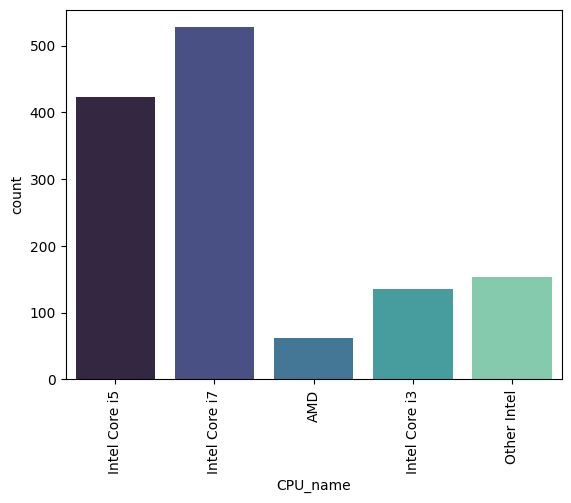

In [143]:
sns.countplot(x=df['CPU_name'],palette='mako')
plt.xticks(rotation = 90)

### CPU Family vs Price

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Intel Core i5'),
  Text(1, 0, 'Intel Core i7'),
  Text(2, 0, 'AMD'),
  Text(3, 0, 'Intel Core i3'),
  Text(4, 0, 'Other Intel')])

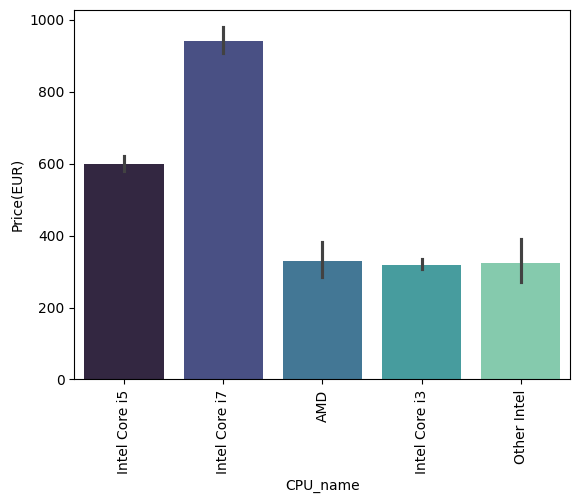

In [144]:
sns.barplot(data=df, x='CPU_name', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 'vertical')

In [145]:
## Drop the original CPU column
df.drop(columns=['CPU'],inplace=True)
df = df.rename(columns={"CPU_name": "CPU"})
df.head()

,Company,TypeName,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU
0,Apple,Ultrabook,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5
1,Apple,Ultrabook,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5
2,HP,Notebook,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5
3,Apple,Ultrabook,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7
4,Apple,Ultrabook,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5


## RAM

##### **Analysis over the `RAM` column**



In [146]:
df['RAM(GB)'].unique()

array([ 8, 16,  4,  2, 12,  6, 32, 24, 64], dtype=int32)

<Axes: xlabel='RAM(GB)', ylabel='count'>

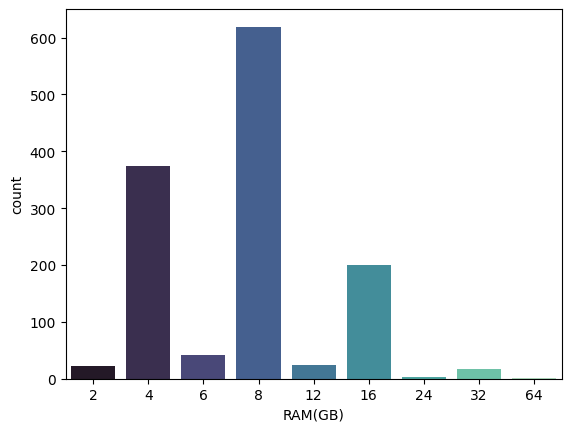

In [147]:
sns.countplot(data=df, x='RAM(GB)',palette='mako', stat='count')

<Axes: xlabel='RAM(GB)', ylabel='Price(EUR)'>

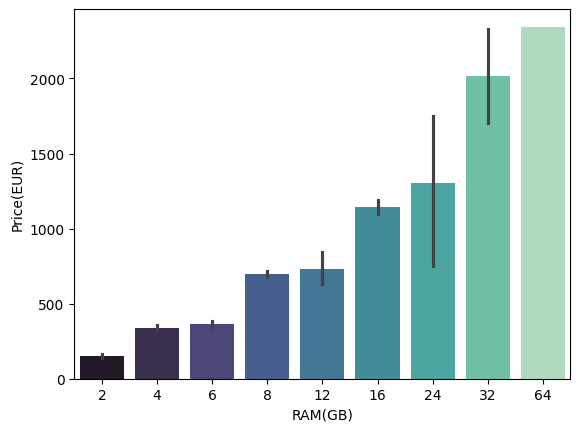

In [148]:
## RAM shows a good relation with price

sns.barplot(data=df, x='RAM(GB)', y='Price(EUR)', palette='mako')

# **Memory**

**We need to discriminate between different *types* of memory, considering for each type its respective value (this has to be done for every laptop in our dataset).**

**Some preprocessing is needed**

In [149]:
df['Memory'].value_counts()

Memory
256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                37
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD         

In [150]:
## We have four main data storage devices : HHD, SSD, Flash, Hybrid

# '\.0' will match any occurrence of the string '.0' in the input text
# that will be removed :
#                         e.g. "1.0TB" --> "1TB"

df['Memory'] = df['Memory'].astype(str).replace('\.0','',regex = True)

# we'll use GB as unit of measure for storage devices
#    * remove "GB"
df['Memory'] = df['Memory'].str.replace('GB','')

#    * 1 TB = 1000 GB, therefore "TB" --> "000"
df['Memory'] = df['Memory'].str.replace('TB','000')

# memory dataframe memdf to store combination of storage devices (if any)
# <mem_storage_device_1>+<mem_storage_device_2>
# '+' : simble to split on
# n=1 : limit for the number of splits in output
# expand=True : expand the split strings into separate columns
memdf = df['Memory'].str.split('+', n=1, expand=True)

memdf

,0,1
0,128 SSD,None
1,128 Flash Storage,None
2,256 SSD,None
3,512 SSD,None
4,256 SSD,None
...,...,...
1298,128 SSD,None
1299,512 SSD,None
1300,64 Flash Storage,None
1301,1000 HDD,None


In [151]:
# clean : remove leading and trailing characters (strip)

df['first_dev'] = memdf[0]
df['first_dev'] = df['first_dev'].str.strip()
df.head()

,Company,TypeName,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,first_dev
0,Apple,Ultrabook,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5,128 SSD
1,Apple,Ultrabook,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5,128 Flash Storage
2,HP,Notebook,8,256 SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5,256 SSD
3,Apple,Ultrabook,16,512 SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7,512 SSD
4,Apple,Ultrabook,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5,256 SSD


In [152]:
cond = df['first_dev'].str.contains('FlashStorage')
df[cond].value_counts()

# we have to check for 'Flash Storage', NOT 'FlashStorage'

Series([], Name: count, dtype: int64)

In [153]:
df.columns

Index(['Company', 'TypeName', 'RAM(GB)', 'Memory', 'Gpu', 'OpSys',
       'Weight(kg)', 'Price(EUR)', 'TouchScreen', 'IPS', 'PPI', 'CPU',
       'first_dev'],
      dtype='object')

In [154]:
def check_memory_1(dev):
    df[dev + '_1'] = df['first_dev'].apply(lambda x:1 if dev in x else 0)


devices = ['HDD','SSD','Hybrid','Flash Storage']
for dev in devices:
    check_memory_1(dev)


df.head()

,Company,TypeName,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,first_dev,HDD_1,SSD_1,Hybrid_1,Flash Storage_1
0,Apple,Ultrabook,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5,128 SSD,0,1,0,0
1,Apple,Ultrabook,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5,128 Flash Storage,0,0,0,1
2,HP,Notebook,8,256 SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5,256 SSD,0,1,0,0
3,Apple,Ultrabook,16,512 SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7,512 SSD,0,1,0,0
4,Apple,Ultrabook,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5,256 SSD,0,1,0,0


In [155]:
# we'll keep just the numerical values :
# the regular expression '\D' (regex=True for it to be actually
# treated as a regular expression) matches any character that is not a digit

df['first_dev'] = df['first_dev'].str.replace(r'\D','', regex=True)
df['first_dev'].value_counts()

first_dev
256     508
1000    250
128     177
512     140
500     132
32       44
64       17
2000     16
16       10
180       5
240       1
8         1
508       1
Name: count, dtype: int64

In [156]:
df['second_dev'] = memdf[1]
df.head()

,Company,TypeName,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,first_dev,HDD_1,SSD_1,Hybrid_1,Flash Storage_1,second_dev
0,Apple,Ultrabook,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5,128,0,1,0,0,None
1,Apple,Ultrabook,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5,128,0,0,0,1,None
2,HP,Notebook,8,256 SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5,256,0,1,0,0,None
3,Apple,Ultrabook,16,512 SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7,512,0,1,0,0,None
4,Apple,Ultrabook,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5,256,0,1,0,0,None


In [157]:
def check_memory_2(dev):

    df[dev + '_2'] = df['second_dev'].apply(lambda x:1 if dev in x else 0)


devices = ['HDD','SSD','Hybrid','Flash Storage']

# many instances only have one memory storage device --> handle NaN
df['second_dev'] = df['second_dev'].fillna("0")
for dev in devices:
    check_memory_2(dev)


# remove all the characters just keep the numbers

df['second_dev'] = df['second_dev'].str.replace(r'\D', '', regex=True)
df['second_dev'].value_counts()

second_dev
0       1094
1000     187
2000      15
256        3
500        2
512        1
Name: count, dtype: int64

In [158]:
df['first_dev'] = df['first_dev'].astype('int')
df['second_dev'] = df['second_dev'].astype('int')
df.head()

,Company,TypeName,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,...,first_dev,HDD_1,SSD_1,Hybrid_1,Flash Storage_1,second_dev,HDD_2,SSD_2,Hybrid_2,Flash Storage_2
0,Apple,Ultrabook,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,...,128,0,1,0,0,0,0,0,0,0
1,Apple,Ultrabook,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,...,128,0,0,0,1,0,0,0,0,0
2,HP,Notebook,8,256 SSD,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,...,256,0,1,0,0,0,0,0,0,0
3,Apple,Ultrabook,16,512 SSD,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,...,512,0,1,0,0,0,0,0,0,0
4,Apple,Ultrabook,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,...,256,0,1,0,0,0,0,0,0,0


In [159]:
# store the results in new columns ['HDD', 'SSD', 'Hybrid', 'FlashStorage']

df["HDD"]=(df["first_dev"]*df["HDD_1"]+df["second_dev"]*df["HDD_2"])
df["SSD"]=(df["first_dev"]*df["SSD_1"]+df["second_dev"]*df["SSD_2"])
df["Hybrid"]=(df["first_dev"]*df["Hybrid_1"]+df["second_dev"]*df["Hybrid_2"])
df["FlashStorage"]=(df["first_dev"]*df["Flash Storage_1"]+df["second_dev"]*df["Flash Storage_2"])


## dropping of uncessary columns

df.drop(columns=['first_dev', 'second_dev', 'HDD_1', 'SSD_1', 'Hybrid_1',
       'Flash Storage_1', 'HDD_2', 'SSD_2', 'Hybrid_2',
       'Flash Storage_2'],inplace=True)

In [160]:
df.sample(5)

,Company,TypeName,RAM(GB),Memory,Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,HDD,SSD,Hybrid,FlashStorage
560,Acer,2 in 1 Convertible,4,32 Flash Storage,Intel HD Graphics 500,Windows 10,1.25,205.841691,1,1,189.905791,Other Intel,0,0,0,32
1104,Lenovo,Gaming,16,512 SSD,Nvidia GeForce GTX 1050 Ti,Windows 10,2.40,707.175322,0,0,141.211998,Intel Core i7,0,512,0,0
1290,Dell,Notebook,6,1000 HDD,Intel HD Graphics 620,Windows 10,2.30,270.720161,0,0,100.454670,Intel Core i3,1000,0,0,0
1217,Lenovo,Notebook,8,1000 HDD,Intel HD Graphics 620,No OS,2.80,317.904503,0,0,106.113062,Intel Core i5,1000,0,0,0
130,Dell,Notebook,8,1000 HDD,AMD Radeon R7 M445,Windows 10,2.36,376.879032,0,0,100.454670,Intel Core i5,1000,0,0,0


In [161]:
df.drop(columns=['Memory'],inplace=True)
df.sample(5)

,Company,TypeName,RAM(GB),Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,HDD,SSD,Hybrid,FlashStorage
1079,HP,Notebook,4,Intel HD Graphics 520,Windows 7,2.31,554.416016,0,0,141.211998,Intel Core i5,500,0,0,0
990,HP,Netbook,8,Intel HD Graphics 515,Windows 10,0.97,1125.346551,0,0,176.232574,Other Intel,0,512,0,0
424,Dell,Gaming,16,Nvidia GeForce GTX 1070,Windows 10,4.42,1650.862157,0,1,169.780899,Intel Core i7,1000,256,0,0
191,Vero,Notebook,4,Intel HD Graphics 500,Windows 10,1.30,153.349111,0,1,157.350512,Other Intel,0,0,0,32
420,Lenovo,2 in 1 Convertible,16,Nvidia GeForce GTX 1050,Windows 10,2.00,1120.038313,1,1,282.423996,Intel Core i7,0,512,0,0


In [162]:
numvars = df.select_dtypes(include = ['int32','int64','float32','float64']).columns
df[numvars].corr()['Price(EUR)']

RAM(GB)         0.742905
Weight(kg)      0.209867
Price(EUR)      1.000000
TouchScreen     0.192917
IPS             0.253320
PPI             0.475368
HDD            -0.096891
SSD             0.670660
Hybrid          0.007942
FlashStorage   -0.040067
Name: Price(EUR), dtype: float64

**Based on the Pearson correlation coefficients, `Hybrid` and `Flash Storage` contributions are negligible, so we can simply drop them off. On the other hand `HDD` and `SDD` both show good correlation with price.**
**With a higher prize we expect to be more likely for the laptop to use SSD instead of HDD and vice versa.**

In [163]:
df.columns

Index(['Company', 'TypeName', 'RAM(GB)', 'Gpu', 'OpSys', 'Weight(kg)',
       'Price(EUR)', 'TouchScreen', 'IPS', 'PPI', 'CPU', 'HDD', 'SSD',
       'Hybrid', 'FlashStorage'],
      dtype='object')

In [164]:
df.drop(columns = ['Hybrid','FlashStorage'],inplace=True)
df.head()

,Company,TypeName,RAM(GB),Gpu,OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,HDD,SSD
0,Apple,Ultrabook,8,Intel Iris Plus Graphics 640,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5,0,128
1,Apple,Ultrabook,8,Intel HD Graphics 6000,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5,0,0
2,HP,Notebook,8,Intel HD Graphics 620,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5,0,256
3,Apple,Ultrabook,16,AMD Radeon Pro 455,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7,0,512
4,Apple,Ultrabook,8,Intel Iris Plus Graphics 650,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5,0,256


# **GPU**

In [165]:
df = df.rename(columns={"Gpu": "GPU"})
df['GPU'].value_counts()

GPU
Intel HD Graphics 620      281
Intel HD Graphics 520      185
Intel UHD Graphics 620      68
Nvidia GeForce GTX 1050     66
Nvidia GeForce GTX 1060     48
                          ... 
Intel Graphics 620           1
AMD Radeon R5 520            1
AMD Radeon R7                1
Intel HD Graphics 540        1
Nvidia GeForce 960M          1
Name: count, Length: 109, dtype: int64

**For the GPU we'll mainly focus on `GPU brands`**

In [166]:
# we go on extracting the brands
a = df['GPU'].iloc[1]
print(a.split()[0])

Intel


<Axes: xlabel='GPU brand', ylabel='count'>

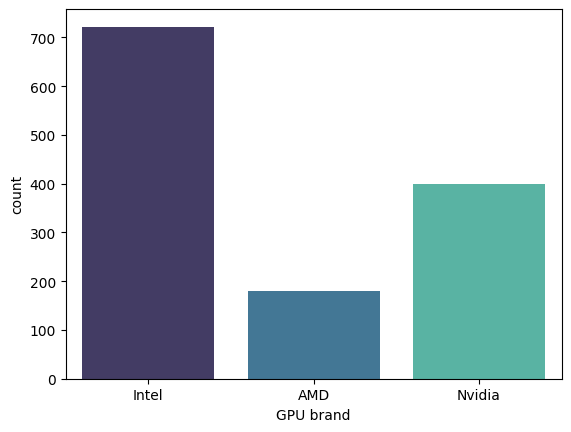

In [167]:
df['GPU brand'] = df['GPU'].apply(lambda x:x.split()[0])
sns.countplot(data=df, x='GPU brand', palette='mako')

<Axes: xlabel='GPU brand', ylabel='count'>

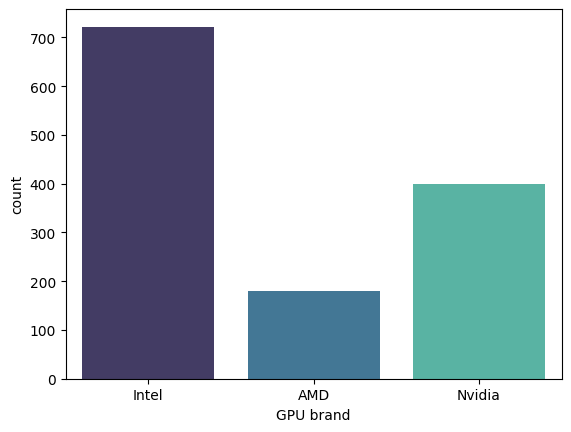

In [168]:
# removing the "ARM" tuple (we already removed it, it was the same that had the 'Samsung' processor, just that one)
# not falling neither in any of the Intel processor families, nor in the AMD one, it was already removed.

df = df[df['GPU brand']!='ARM']
sns.countplot(data=df, x='GPU brand', palette='mako')

<Axes: xlabel='GPU brand', ylabel='Price(EUR)'>

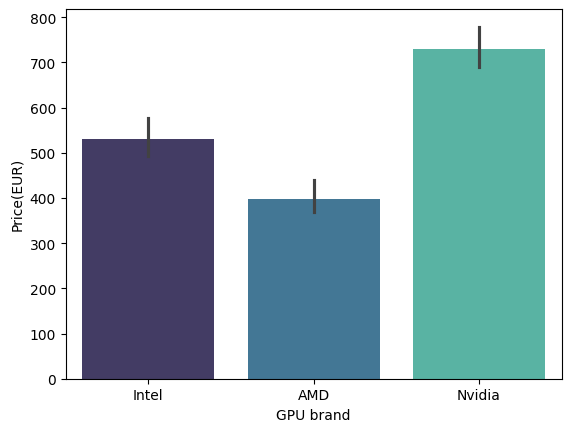

In [169]:
# price-GPU analysis
# tried to use np.median to check if outliers have any inpact, it doesn't seem so

sns.barplot(data=df, x='GPU brand', y='Price(EUR)', estimator=np.median, palette='mako')

In [170]:
df = df.drop(columns=['GPU'])
df.head()

,Company,TypeName,RAM(GB),OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,HDD,SSD,GPU brand
0,Apple,Ultrabook,8,macOS,1.37,790.154885,0,1,226.983005,Intel Core i5,0,128,Intel
1,Apple,Ultrabook,8,macOS,1.34,530.198652,0,0,127.677940,Intel Core i5,0,0,Intel
2,HP,Notebook,8,No OS,1.86,339.137456,0,0,141.211998,Intel Core i5,0,256,Intel
3,Apple,Ultrabook,16,macOS,1.83,1496.598850,0,1,220.534624,Intel Core i7,0,512,AMD
4,Apple,Ultrabook,8,macOS,1.37,1063.770985,0,1,226.983005,Intel Core i5,0,256,Intel


# **Operating System**

In [171]:
df['OpSys'].value_counts()

OpSys
Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         26
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: count, dtype: int64

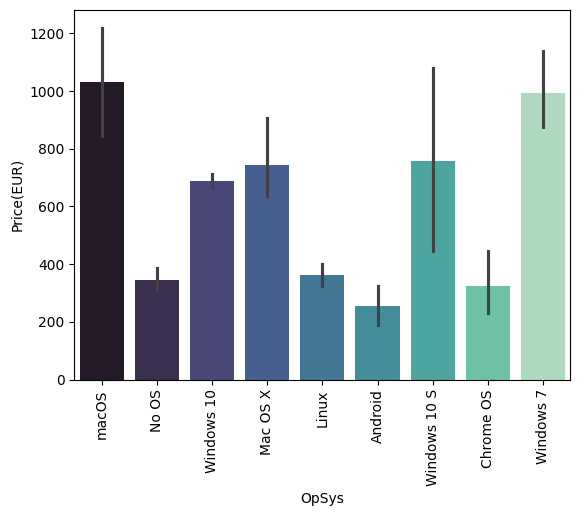

In [172]:
sns.barplot(data=df, x='OpSys', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 90)
plt.show()

In [173]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

In [174]:
# [Windows 10,Windows 7,Windows 7 S] --> Windows
# [macOS, mac OS X]                  --> MacOS
# Linux                              --> Linux
# everything else                    --> Other

def setcategory(text):

    if text=='Windows 10' or text=='Windows 7' or text=='Windows 10 S':
        return 'Windows'

    elif text=='Mac OS X' or text=='macOS':
        return 'MacOS'

    elif text=='Linux':
        return 'Linux'

    else:
        return 'Other'


df['OpSys'] = df['OpSys'].apply(lambda x:setcategory(x))

df.head()

,Company,TypeName,RAM(GB),OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,HDD,SSD,GPU brand
0,Apple,Ultrabook,8,MacOS,1.37,790.154885,0,1,226.983005,Intel Core i5,0,128,Intel
1,Apple,Ultrabook,8,MacOS,1.34,530.198652,0,0,127.677940,Intel Core i5,0,0,Intel
2,HP,Notebook,8,Other,1.86,339.137456,0,0,141.211998,Intel Core i5,0,256,Intel
3,Apple,Ultrabook,16,MacOS,1.83,1496.598850,0,1,220.534624,Intel Core i7,0,512,AMD
4,Apple,Ultrabook,8,MacOS,1.37,1063.770985,0,1,226.983005,Intel Core i5,0,256,Intel


In [175]:
df.sample(5)

,Company,TypeName,RAM(GB),OpSys,Weight(kg),Price(EUR),TouchScreen,IPS,PPI,CPU,HDD,SSD,GPU brand
445,Dell,Notebook,8,Windows,1.64,695.379237,0,0,157.350512,Intel Core i5,0,256,Nvidia
155,HP,Notebook,6,Windows,1.91,365.088844,0,0,141.211998,Intel Core i5,0,256,AMD
252,Asus,Notebook,4,Windows,1.68,276.618204,0,0,100.454670,AMD,1000,0,AMD
469,Lenovo,Ultrabook,12,Windows,1.40,1095.856337,0,1,209.800683,Intel Core i7,0,256,Intel
170,Huawei,Ultrabook,8,Windows,1.05,795.645963,0,1,199.692071,Intel Core i5,0,256,Intel


<Axes: xlabel='OpSys', ylabel='count'>

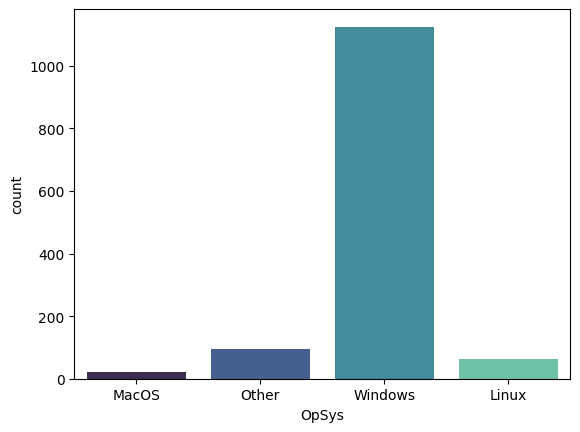

In [176]:
sns.countplot(data=df, x='OpSys', palette='mako')

([0, 1, 2, 3],
 [Text(0, 0, 'MacOS'),
  Text(1, 0, 'Other'),
  Text(2, 0, 'Windows'),
  Text(3, 0, 'Linux')])

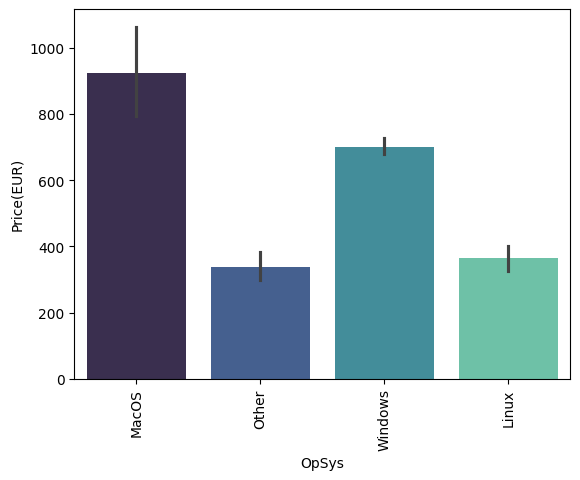

In [177]:
sns.barplot(data=df, x='OpSys', y='Price(EUR)', palette='mako')
plt.xticks(rotation = 90)

### Weight analysis

<Axes: xlabel='Weight(kg)', ylabel='Density'>

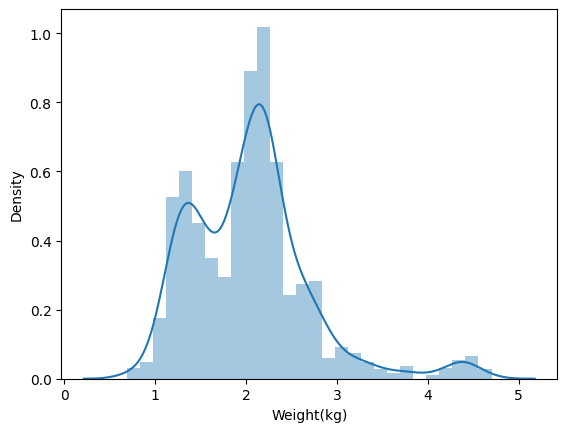

In [178]:
sns.distplot(df['Weight(kg)'])

#### Weight vs Price

<Axes: xlabel='Weight(kg)', ylabel='Price(EUR)'>

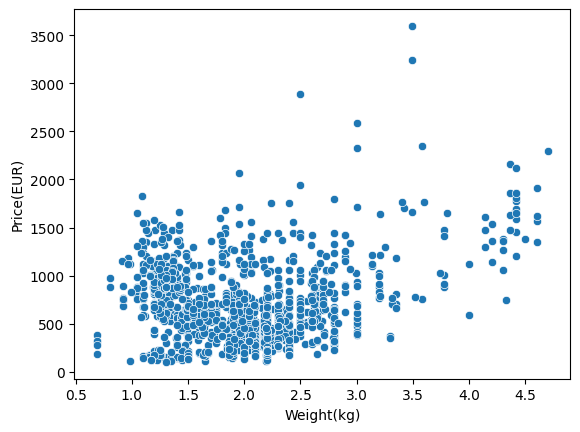

In [179]:
sns.scatterplot(data=df, x='Weight(kg)', y='Price(EUR)')

# **Price Analysis**

<Axes: xlabel='Price(EUR)', ylabel='Density'>

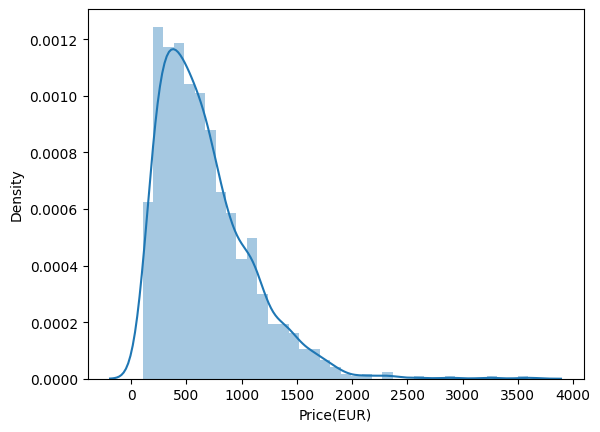

In [180]:
sns.distplot(df['Price(EUR)'])

The `Price(EUR)` column has a right-skewed distribution: the tail on the right side of the distribution is heavier than the one on the left side, showing how data is not symmetrically distributed around the mean. Applying a log transformation can help to stabilize the variance and normalize the distribution by compressing the range of large values and stretching out the range of small values.
As we can see below, this transformation effectively reduces the impact of outliers and makes the data more symmetric.
As a result, the transformed data approximates a Gaussian (normal) distribution, which is often easier to analyze and model using statistical techniques that assume normality.



[Text(0.5, 0, 'log(Price(EUR))'), Text(0, 0.5, 'Density')]

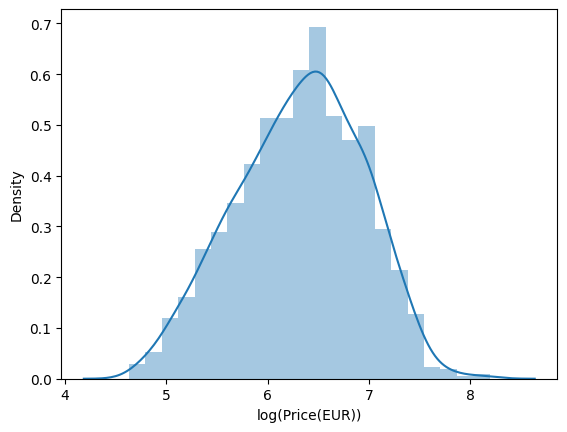

In [181]:
# by applying np.log to the 'Price' column we get a gaussian distibution

ax = sns.distplot(np.log(df['Price(EUR)']))
ax.set(xlabel='log(Price(EUR))', ylabel='Density')

In [182]:
df.rename(columns={"Price(EUR)":"Price(€)"}, inplace=True)
df = df[['Company','TypeName','RAM(GB)','OpSys','Weight(kg)','TouchScreen','IPS','PPI','CPU','HDD','SSD','GPU brand', 'Price(€)']]
df.head()

,Company,TypeName,RAM(GB),OpSys,Weight(kg),TouchScreen,IPS,PPI,CPU,HDD,SSD,GPU brand,Price(€)
0,Apple,Ultrabook,8,MacOS,1.37,0,1,226.983005,Intel Core i5,0,128,Intel,790.154885
1,Apple,Ultrabook,8,MacOS,1.34,0,0,127.677940,Intel Core i5,0,0,Intel,530.198652
2,HP,Notebook,8,Other,1.86,0,0,141.211998,Intel Core i5,0,256,Intel,339.137456
3,Apple,Ultrabook,16,MacOS,1.83,0,1,220.534624,Intel Core i7,0,512,AMD,1496.598850
4,Apple,Ultrabook,8,MacOS,1.37,0,1,226.983005,Intel Core i5,0,256,Intel,1063.770985


In [183]:
# correlation with other features
numvars = df.select_dtypes(include = ['int32','int64','float32','float64']).columns
df[numvars].corr()['Price(€)']

RAM(GB)        0.742905
Weight(kg)     0.209867
TouchScreen    0.192917
IPS            0.253320
PPI            0.475368
HDD           -0.096891
SSD            0.670660
Price(€)       1.000000
Name: Price(€), dtype: float64

<Axes: >

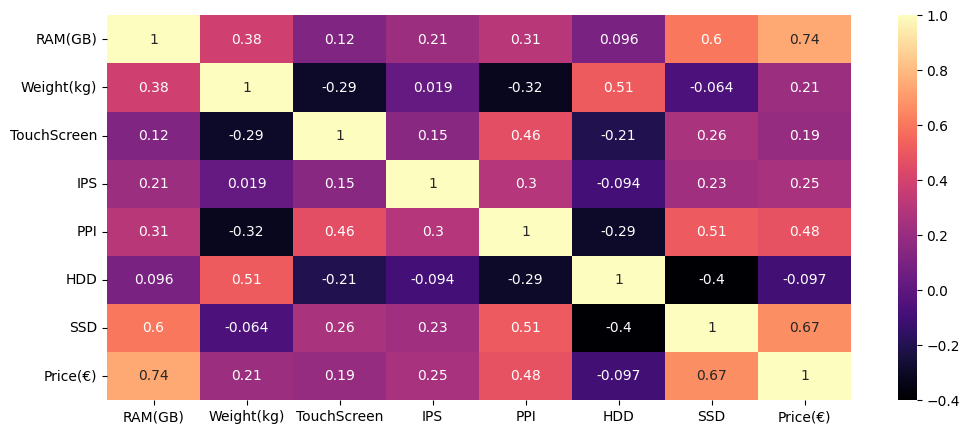

In [184]:
plt.figure(figsize=(12,5))
sns.heatmap(df[numvars].corr(), annot=True, cmap='magma')

<small>write dataframe

In [84]:
# df.to_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv')

<small>reload dataframe

In [85]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)

# **Model Building**

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

In [87]:
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

X_train.shape, X_test.shape

((1106, 12), (196, 12))

**We'll widely use `Column Trasnformer` to build our models using `Pipelines`. To simplify future operations we get the index numbers of the categorical features (columns)**

In [88]:
X_train.sample()

,Company,TypeName,RAM(GB),OpSys,Weight(kg),TouchScreen,IPS,PPI,CPU,HDD,SSD,GPU brand
90,Asus,Gaming,8,Windows,2.45,0,0,141.211998,AMD,1000,0,AMD


In [89]:
mapper = {i:item for i,item in enumerate(X_train.columns)}
mapper

{0: 'Company',
 1: 'TypeName',
 2: 'RAM(GB)',
 3: 'OpSys',
 4: 'Weight(kg)',
 5: 'TouchScreen',
 6: 'IPS',
 7: 'PPI',
 8: 'CPU',
 9: 'HDD',
 10: 'SSD',
 11: 'GPU brand'}

# **Linear Regression**

**One Hot Encoding for the categorical features:**
1. Company (0)
2. TypeName (1)
3. OpSys (3)
4. CPU (8)
5. GPU brand (11)

One-hot encoding is a technique used to convert categorical data into a numerical format that can be provided to machine learning algorithms.
As a result of this step each category will be represented as a binary vector where only one element is '1' (indicating the presence of that category) and all other elements are '0'.

In [90]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

ohe = ColumnTransformer(
    transformers=[('onehot',OneHotEncoder(sparse=False,drop='first'),[0,1,3,8,11])],

    # we need to keep the other columns unchanged
    remainder='passthrough'
)

lr = LinearRegression()

pipe_lr = Pipeline([
    ('ohe', ohe),
    ('lr', lr)
])

pipe_lr.fit(X_train,y_train)

y_pred = pipe_lr.predict(X_test)

print('-'*50)
print('Linear Regression')
print('R2 score : \t', metrics.r2_score(y_test,y_pred))
print('MAE : \t\t', metrics.mean_absolute_error(y_test,y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Linear Regression
R2 score : 	 0.8067729390471987
MAE : 		 0.21011396168486424
RMSE : 		 0.07391922852834454
--------------------------------------------------


# **Ridge Regression**

In [91]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

ohe = ColumnTransformer(
    transformers=[('onehot',OneHotEncoder(sparse=False,drop='first'),[0,1,3,8,11])],
    remainder='passthrough'
)

ridge = Ridge(alpha=10)

pipe_ridge = Pipeline([
    ('ohe', ohe),
    ('ridge', ridge)
])

pipe_ridge.fit(X_train,y_train)

y_pred = pipe_ridge.predict(X_test)

print('-'*50)
print('Ridge Regression')
print('R2 score : \t',metrics.r2_score(y_test,y_pred))
print('MAE : \t\t',metrics.mean_absolute_error(y_test,y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Ridge Regression
R2 score : 	 0.8127240627874481
MAE : 		 0.2095188204743929
RMSE : 		 0.07164261947789995
--------------------------------------------------


# **LassoRegression**

In [92]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

ohe = ColumnTransformer(
    transformers=[('onehot',OneHotEncoder(sparse=False,drop='first'),[0,1,3,8,11])],
    remainder='passthrough'
)

lasso = Lasso(alpha=0.001)

pipe_lasso = Pipeline([
    ('ohe', ohe),
    ('lasso', lasso)
])

pipe_lasso.fit(X_train,y_train)

y_pred = pipe_lasso.predict(X_test)

print('-'*50)
print('Lasso Regression')
print('R2 score : \t',metrics.r2_score(y_test,y_pred))
print('MAE : \t\t',metrics.mean_absolute_error(y_test,y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Lasso Regression
R2 score : 	 0.8071016911884541
MAE : 		 0.21156263228051508
RMSE : 		 0.07379346402859581
--------------------------------------------------


# **Decision Tree**

In [93]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

ohe = ColumnTransformer(
    transformers=[('onehot',OneHotEncoder(sparse=False,drop='first'),[0,1,3,8,11])],
    remainder='passthrough'
)

dt = DecisionTreeRegressor(max_depth=8)

pipe_dt = Pipeline([
    ('ohe', ohe),
    ('tree', dt)
])

pipe_dt.fit(X_train,y_train)

y_pred = pipe_dt.predict(X_test)

print('-'*50)
print('Decision Tree Regressor')
print('R2 score : \t',metrics.r2_score(y_test,y_pred))
print('MAE : \t\t',metrics.mean_absolute_error(y_test,y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Decision Tree Regressor
R2 score : 	 0.8396505951618242
MAE : 		 0.18207297294063404
RMSE : 		 0.06134184436781558
--------------------------------------------------


# **Random Forest**

In [94]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

ohe = ColumnTransformer(
    transformers=[('onehot',OneHotEncoder(sparse=False,drop='first'),[0,1,3,8,11])],
    remainder='passthrough'
)

rf = RandomForestRegressor(
            n_estimators=100,
            random_state=3,
            max_samples=0.5,
            max_features=0.75,
            max_depth=15
)

pipe_rf = Pipeline([
    ('ohe', ohe),
    ('forest', rf)
])

pipe_rf.fit(X_train,y_train)

y_pred = pipe_rf.predict(X_test)

print('-'*50)
print('Random Forest Regressor')
print('R2 score : \t',metrics.r2_score(y_test,y_pred))
print('MAE : \t\t',metrics.mean_absolute_error(y_test,y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Random Forest Regressor
R2 score : 	 0.8819807610185106
MAE : 		 0.16267052308685204
RMSE : 		 0.045148392021265395
--------------------------------------------------


## **KNN with Hyperparameter Tuning**

In [95]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

ohe = ColumnTransformer(
    transformers=[('col_tnf', OneHotEncoder(sparse=False, drop='first'), [0, 1, 3, 8, 11])],
    remainder='passthrough'
)

knn = KNeighborsRegressor()

pipe_knn = Pipeline([
    ('step1', ohe),
    ('step2', knn)
])

# Parameter grid for Hyperparameter Tuning
param_grid = {
    'step2__n_neighbors': [3, 5, 7, 9],
    'step2__weights': ['uniform', 'distance'],
    'step2__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(pipe_knn, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_knn_pipe = grid_search.best_estimator_
y_pred = best_knn_pipe.predict(X_test)

# Evaluate the performance
print("-" * 50)
print('KNN with Hyperparameter Tuning')
print('Best parameters found: ', grid_search.best_params_)
print('R2 score : \t', metrics.r2_score(y_test, y_pred))
print('MAE : \t\t', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
KNN with Hyperparameter Tuning
Best parameters found:  {'step2__algorithm': 'auto', 'step2__n_neighbors': 5, 'step2__weights': 'distance'}
R2 score : 	 0.8310506543164828
MAE : 		 0.17873976296376842
RMSE : 		 0.0646317613677554
--------------------------------------------------


## **RandomForestRegressor with Hyperparameter Tuning**

In [96]:
df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

indexlist = [0,1,3,8,11]
catvars = []
for key,value in mapper.items():
    if key in indexlist:
        catvars.append(value)

X = pd.get_dummies(X, columns=catvars, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

# Here we use the best parameters found in grid_search.best_params_ after GridSearchCV
rf_best = RandomForestRegressor(
    bootstrap=False,
    max_depth= 15,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=300
)

rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)

# Evaluate the performance
print("-" * 50)
print('Random Forest with Hyperparameter Tuning')
print('R2 score : \t', metrics.r2_score(y_test, y_pred))
print('MAE : \t\t', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Random Forest with Hyperparameter Tuning
R2 score : 	 0.9013422557570787
MAE : 		 0.14963047033388802
RMSE : 		 0.037741630529508595
--------------------------------------------------


In [97]:
import pickle

pickle.dump(pipe_lr,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_lr.pkl','wb'))
pickle.dump(pipe_ridge,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_ridge.pkl','wb'))
pickle.dump(pipe_lasso,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_lasso.pkl','wb'))
pickle.dump(pipe_dt,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_dt.pkl','wb'))
pickle.dump(pipe_rf,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_rf.pkl','wb'))
pickle.dump(best_knn_pipe,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_knn.pkl','wb'))
pickle.dump(rf_best,open('/content/drive/MyDrive/LaptopPricePredictor/models/pipe_rf_best.pkl','wb'))

In [98]:
indexlist = [0,1,3,8,11]
catvars = []
for key,value in mapper.items():
    if key in indexlist:
        catvars.append(value)

df = pd.read_csv('/content/drive/MyDrive/LaptopPricePredictor/data/preprocesseddata.csv', index_col=0)

X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X = pd.get_dummies(X, columns=catvars, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

y_pred = rf_best.predict(X_test)

# Evaluate the performance
print("-" * 50)
print('Random Forest with Hyperparameter Tuning')
print('Best parameters found: ', grid_search.best_params_)
print('R2 score : \t', metrics.r2_score(y_test, y_pred))
print('MAE : \t\t', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE : \t\t', metrics.mean_squared_error(y_test, y_pred))
print('-'*50)

--------------------------------------------------
Random Forest with Hyperparameter Tuning
Best parameters found:  {'step2__algorithm': 'auto', 'step2__n_neighbors': 5, 'step2__weights': 'distance'}
R2 score : 	 0.9013422557570787
MAE : 		 0.14963047033388802
RMSE : 		 0.037741630529508595
--------------------------------------------------


## **Plot Accuracy on Test set**

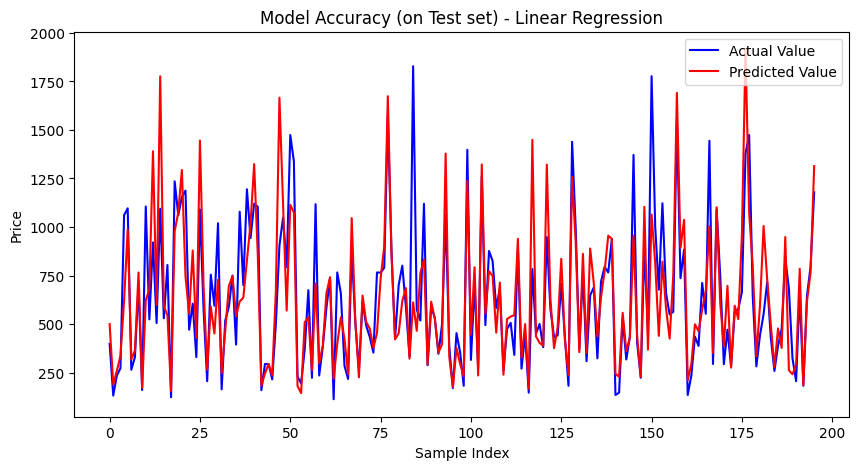

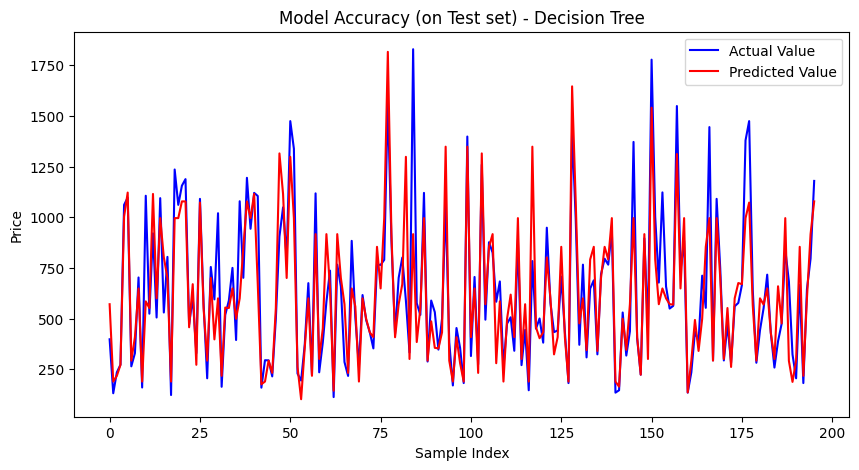

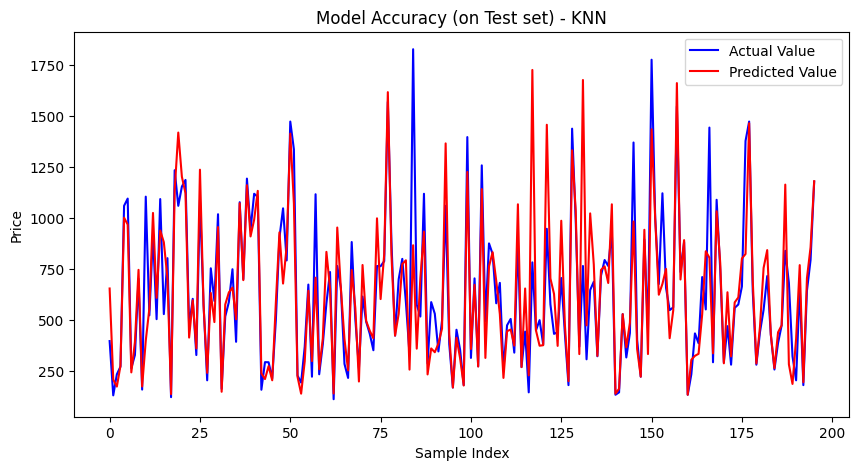

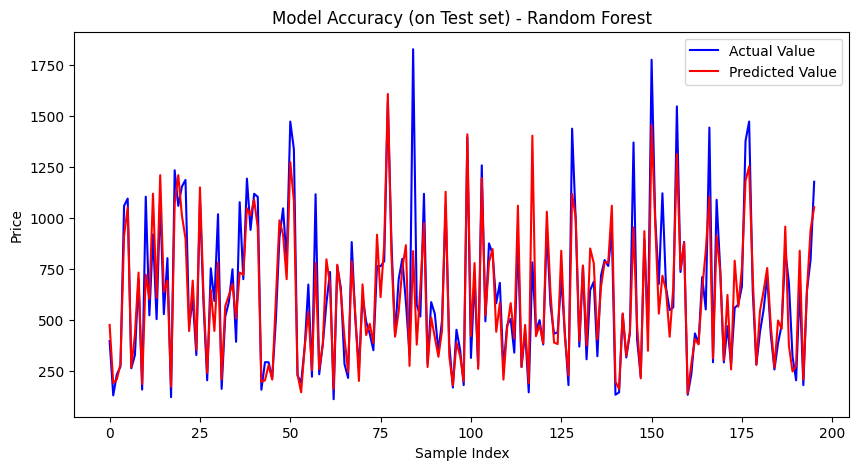

In [99]:
X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

y_pred = pipe_lr.predict(X_test)
y_actual = y_test

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(np.exp(y_actual.values), label='Actual Value', color='blue')
plt.plot(np.exp(y_pred), label='Predicted Value', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Model Accuracy (on Test set) - Linear Regression')
plt.legend()
plt.show()



y_pred = pipe_dt.predict(X_test)

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(np.exp(y_actual.values), label='Actual Value', color='blue')
plt.plot(np.exp(y_pred), label='Predicted Value', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Model Accuracy (on Test set) - Decision Tree')
plt.legend()
plt.show()


y_pred = best_knn_pipe.predict(X_test)

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(np.exp(y_actual.values), label='Actual Value', color='blue')
plt.plot(np.exp(y_pred), label='Predicted Value', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Model Accuracy (on Test set) - KNN')
plt.legend()
plt.show()


X = df.drop(['Price(€)'],axis = 1)
y = np.log(df['Price(€)'])

X = pd.get_dummies(X, columns=catvars, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=2
)

y_pred = rf_best.predict(X_test)
y_actual = y_test

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 5))
plt.plot(np.exp(y_actual.values), label='Actual Value', color='blue')
plt.plot(np.exp(y_pred), label='Predicted Value', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Model Accuracy (on Test set) - Random Forest')
plt.legend()
plt.show()
